<a href="https://colab.research.google.com/github/ayanga1998/RNN-Price-Prediction/blob/main/Code/RNN_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Methods for Cryptocurrency Price Prediction

**Purpose:** This notebook serves as a complete guide/walkthrough on how to utilize popular neural network architectures for cryptocurrency price predicitons

## Overview



1.   **Dependencies**
2.   **Importing the data**
3.   **Exploratory Data Analysis**
4.   **Data Preprocessing**
5.   **Model Implementation**
6.   **Closing Remarks**



## 1. Importing Dependencies

For this notebook, we will be using PyTorch to implement our model. We will leverage such as pandas, numpy, matplotlib, sci-kit learn, etc. for analysis and processing purposes.

In [5]:
!pip install torchinfo

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import shutil
from torch import nn
from torch.nn import functional as F 
from torch.utils.data import Dataset, DataLoader, random_split 
from torchinfo import summary 

In [7]:
plt.style.use('seaborn')

## 2. Importing the data

For this notebook we will focus on predicting the price of Ether Coin (ETH). We will be working with Ether price data on an hourly timescale spanning from 2016 to 2021. This time period along with the granularity leads us to have around 40,000 data points in our time series data.

In [8]:
data_url = 'https://raw.githubusercontent.com/ayanga1998/RNN-Price-Prediction/main/Data/ethereum_data.csv'

data = pd.read_csv(data_url)
data['time'] = pd.to_datetime(data.time)
data.head()

,time,open,close,high,low,volume,trade_count,num_blocks,avg_diff,avg_gas_limit,total_gas_used,avg_block_size,num_transactions
0,2016-10-18 00:00:00+00:00,12.02591,12.03000,12.03000,12.02591,76.942100,6.0,264,91778123286852,500184.537879,53473057,1467.477273,1806
1,2016-10-18 01:00:00+00:00,12.03000,12.00000,12.03000,12.00000,146.279800,3.0,231,91398787596245,500212.653680,38422300,1268.463203,1231
2,2016-10-18 02:00:00+00:00,12.03807,12.01021,12.07878,12.01021,63.027896,11.0,256,90785177574172,500157.984375,49230565,1428.851563,1790
3,2016-10-18 03:00:00+00:00,12.01486,12.20000,12.20000,12.01486,1303.990710,33.0,238,90854932959753,500241.428571,43352747,1358.861345,1374
4,2016-10-18 04:00:00+00:00,12.20000,12.31500,12.48750,12.20000,2274.409322,74.0,259,90033709920638,500240.220077,52125533,1467.679537,1911


## 2.1 Dataset Description

Our original dataset contains 11 features -- the first being the timestamp of each observtion, the next four being price specific features, and the remaining features being Ethereum blockchain specific data. The features are summarized below:


**Price Data**

*   **time**: The timestamp for each observation
*   **open**: The price value of Ether coin at the start of each hour 
*   **close**: The price value of Ether coin at the close of each hour
*   **high**: The highest price value of Ether coin recorded during the duration of each recorded period
*   **low**: The lowest recorded price value of Ether coin throughout each houlry period
*   **volume**: The total amount of Ether coin units traded during each hourly period
*   **trade_count**: The total number of Ether coin trades executded during each period

**Ethereum Blockchain Data**

*   **avg_diff**: Average difficulty level of problems needed to be solved by miners to find a block
*   **avg_gas_limit**: The average gas limit, i.e., the average limit for the cost necessary to execute a transaction on the Ethereum Blockchain per hour
*   **avg_gas_used**: The average amount of gas actually used to execute a transaction on the Ethereum network
*   **avg_trans_count**: The average number of transactions executed on each block for a given hourly period

The description above, particularly with respect to blockchain information, is by no means complete and only included to give insight into the data used for this particular project. I highly recommend the reader to explore deeper into the nuances of the Ethereum blockchain. 

I will admit, I am no expert when it comes to cryptocurrency. In fact, I had to do a bit of reading as to whether or not I should include blockchain information in my feature space. It became clear that the Ethereum blockchain activity can be a strong indicator for price behavior. There are several implementations in literature that vouch for the utility of blockchain information in price prediction models for cryptocurrency with "better-than-baseline" results for Ethereum and Bitcoin specifically. 


**Resources:**

[Predicting Ethereum prices with machine learning based on Blockchain information](https://www.sciencedirect.com/science/article/abs/pii/S0957417421008915?casa_token=zjo_PiMfgpkAAAAA:mBlw05ZlRp8b5oR7u3U8IJCflrIdaXLxDg1_5VB0NkOBqqewrg99Uqh1vc-P-EzSbLFRrU02K7I)

[An Empirical Study on Modeling and Prediction of Bitcoin Prices With Bayesian Neural Networks Based on Blockchain Information](https://ieeexplore.ieee.org/document/8125674)



### Data Sources

Price data was gathered using Coin API. Blockchain information was collected through the Ethereum BigQuery Dataset hosted on Kaggle. 

Blockchain Information Collection: [Kaggle Notebook](https://www.kaggle.com/arnoldyanga/extracting-hourly-block-information)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   time              43848 non-null  datetime64[ns, UTC]
 1   open              43848 non-null  float64            
 2   close             43848 non-null  float64            
 3   high              43848 non-null  float64            
 4   low               43848 non-null  float64            
 5   volume            43848 non-null  float64            
 6   trade_count       43848 non-null  float64            
 7   num_blocks        43848 non-null  int64              
 8   avg_diff          43848 non-null  int64              
 9   avg_gas_limit     43848 non-null  float64            
 10  total_gas_used    43848 non-null  int64              
 11  avg_block_size    43848 non-null  float64            
 12  num_transactions  43848 non-null  int64              
dtypes

In [10]:
print(f'Start date: {data["time"].min()}')
print(f'End date: {data["time"].max()}')

Start date: 2016-10-18 00:00:00+00:00
End date: 2021-10-18 23:00:00+00:00


In [11]:
data.set_index('time', inplace=True) 

## 3. Exploratory Data Analysis

In [12]:
price = data['close']

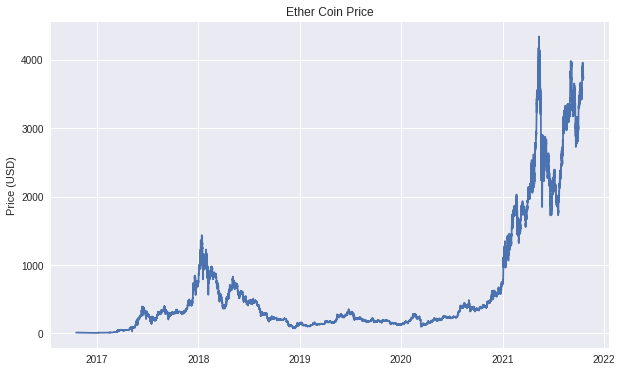

In [9]:
plt.figure(figsize=(10,6))
plt.plot(price)
plt.ylabel('Price (USD)')
plt.title('Ether Coin Price')
plt.show()

**Log Returns**

Plotting the log-return of Ether Coin price data paints a different picture than that of the plot above. Using log returns allows us to render our original price signal stationary. While we may lose information on price trends, we gain insight into the hourly interactions of the price data.

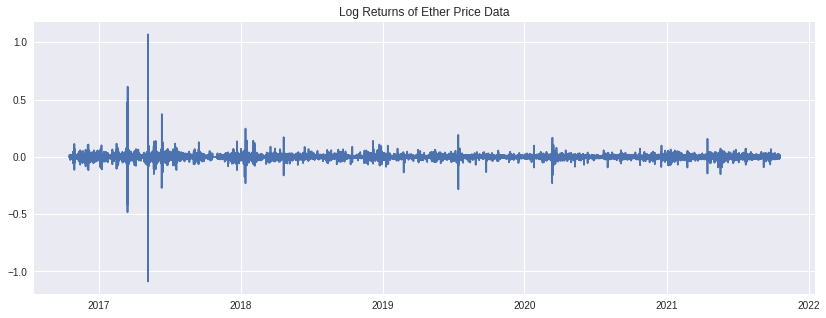

In [10]:
eth_log_return = data['close'].apply(np.log).diff(1).fillna(0)

plt.figure(figsize=(14,5))
plt.plot(eth_log_return)
plt.title('Log Returns of Ether Price Data')
plt.show()

The distribution of log-returns show a nicely shaped curve with a sharp peak (mean) centered at approximately 0. 

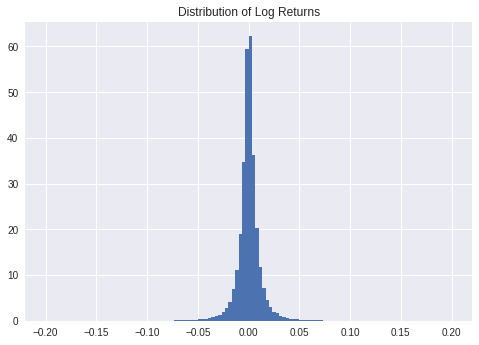

In [11]:
plt.hist(eth_log_return, range=(-0.2,0.2), bins=120, density=True)
plt.title('Distribution of Log Returns')
plt.show()

Using the data for log-returns, let's plot some rolling statistics for values such as skew, kurtosis, standard deviation, and mean.

The **rolling mean** gives us a sliding window perspective of how the average log return shifts over time. 

The **rolling standard deviation** can be interpreted as a measure of volatility i.e., how likely are the log-returns to vary over time.

The **rolling skew** gives us a measurement of the symmetry of log returns over the specified window. From the plot we notice distinct spikes in the graph, indicating potential breakout regions for price values

The **rolling kurtosis** is a measure of which log-returns may appear in the tail of our distribution. We notice extremely high values of kurtosis which can be indicative of risk,i.e, excessive gains or losses

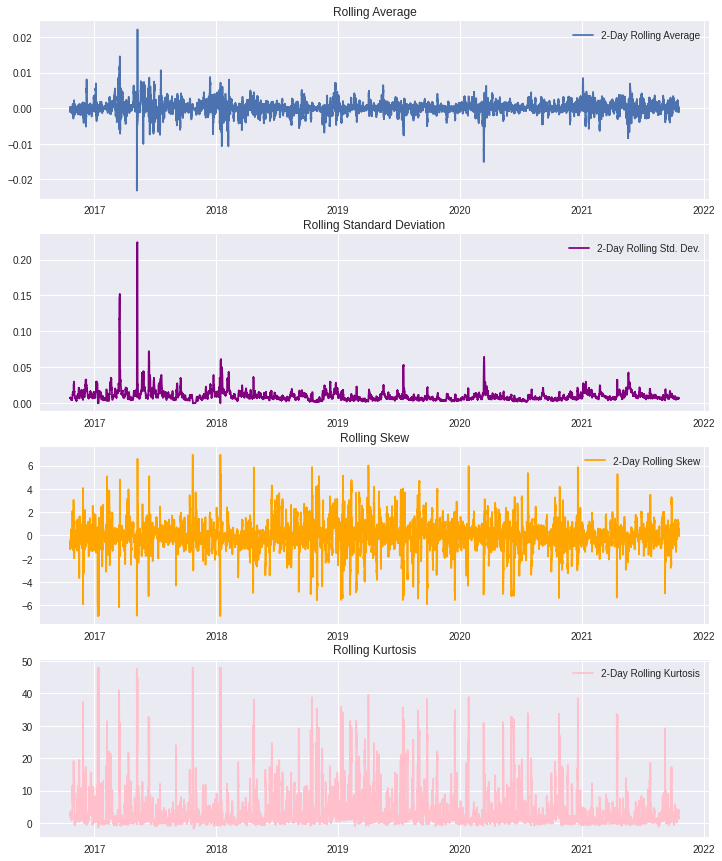

In [12]:
fig, ax = plt.subplots(4, figsize=(12,15))
ax[0].plot(eth_log_return.rolling(48).mean(), label='2-Day Rolling Average')
ax[0].set_title('Rolling Average')
ax[0].legend()

ax[1].plot(eth_log_return.rolling(48).std(), label='2-Day Rolling Std. Dev.', color='purple')
ax[1].set_title('Rolling Standard Deviation')
ax[1].legend()

ax[2].plot(eth_log_return.rolling(48).skew(), label='2-Day Rolling Skew', color='orange')
ax[2].set_title('Rolling Skew')
ax[2].legend()

ax[3].plot(eth_log_return.rolling(48).kurt(), label='2-Day Rolling Kurtosis', color='pink')
ax[3].set_title('Rolling Kurtosis')
ax[3].legend()

plt.show()

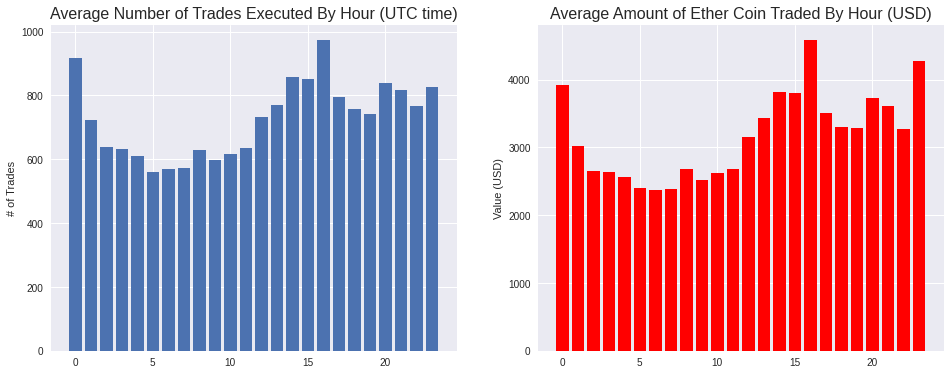

In [13]:
hourly_data = data.groupby(data.index.hour).mean()

fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].bar(x=hourly_data.index, height=hourly_data['trade_count'])
ax[0].set_title('Average Number of Trades Executed By Hour (UTC time)', fontsize=16)
ax[0].set_ylabel('# of Trades')

ax[1].bar(x=hourly_data.index, height=hourly_data['volume'], color='red')
ax[1].set_title('Average Amount of Ether Coin Traded By Hour (USD)', fontsize=16)
ax[1].set_ylabel('Value (USD)')
plt.show()

[]

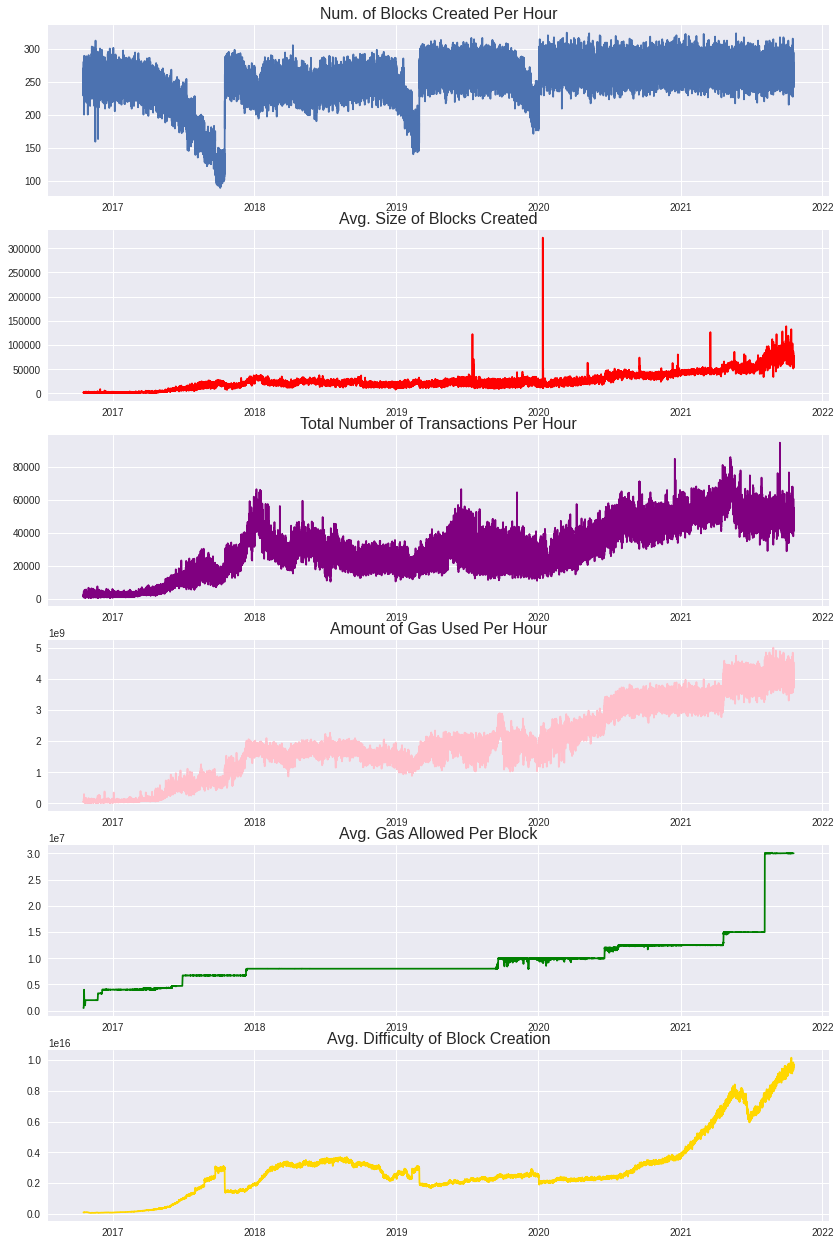

In [14]:
fig, ax = plt.subplots(6, figsize=(14,22))

ax[0].plot(data['num_blocks'])
ax[0].set_title('Num. of Blocks Created Per Hour', fontsize=16)

ax[1].plot(data['avg_block_size'], color='red')
ax[1].set_title('Avg. Size of Blocks Created', fontsize=16)

ax[2].plot(data['num_transactions'], color='purple')
ax[2].set_title('Total Number of Transactions Per Hour', fontsize=16)

ax[3].plot(data['total_gas_used'], color='pink')
ax[3].set_title('Amount of Gas Used Per Hour', fontsize=16)

ax[4].plot(data['avg_gas_limit'], color='green')
ax[4].set_title('Avg. Gas Allowed Per Block', fontsize=16)

ax[5].plot(data['avg_diff'], color='gold')
ax[5].set_title('Avg. Difficulty of Block Creation', fontsize=16)

plt.plot()

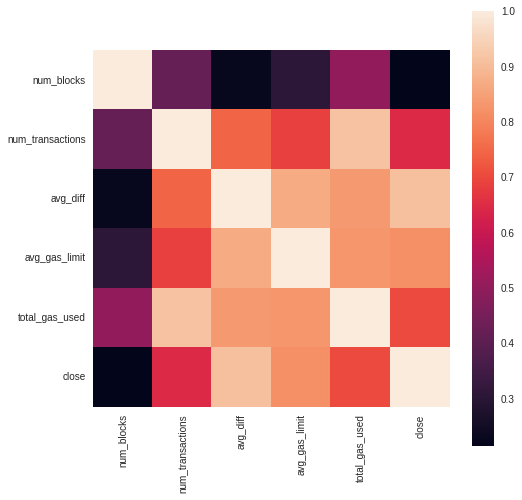

In [15]:
import seaborn as sns

features = ['num_blocks','num_transactions', 'avg_diff', 'avg_gas_limit','total_gas_used', 'close']
block_corr = data[features].corr()

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(block_corr, square=True)
plt.show('Correlation Heatmap for Blockchain Info')
plt.show()

[]

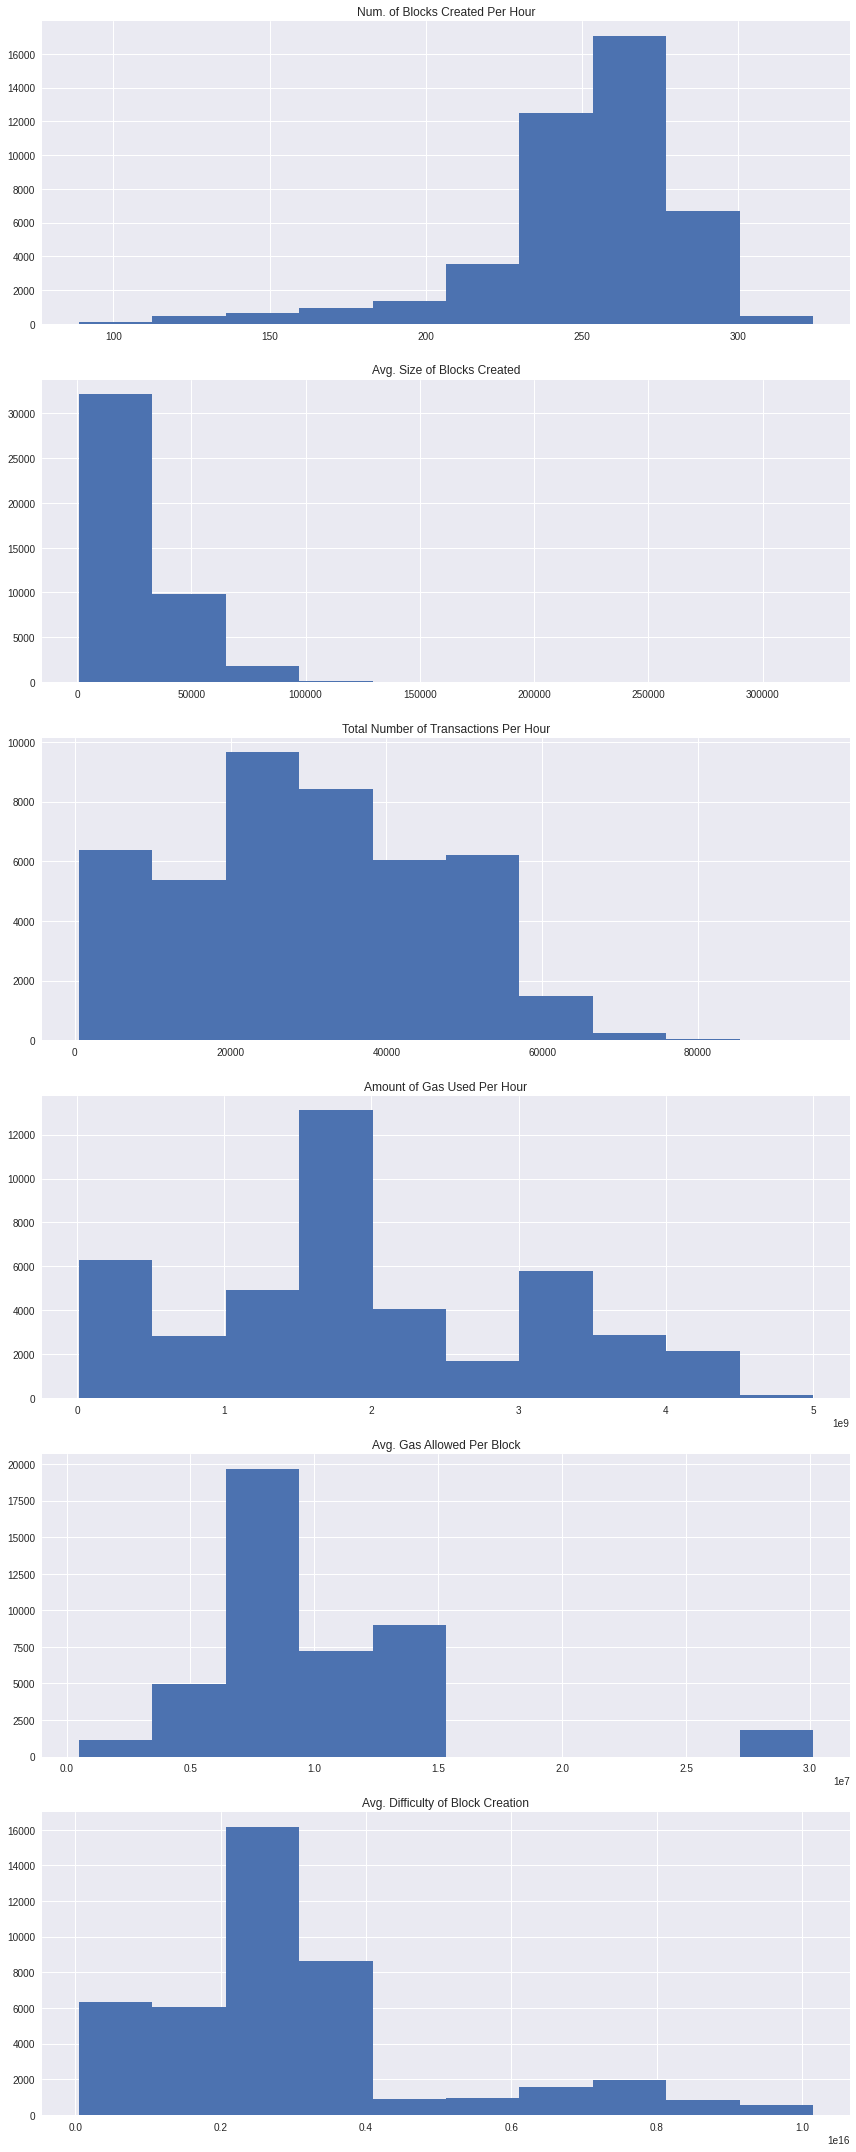

In [16]:
fig, ax = plt.subplots(6, figsize=(12,30))

ax[0].hist(data['num_blocks'])
ax[0].set_title('Num. of Blocks Created Per Hour')

ax[1].hist(data['avg_block_size'])
ax[1].set_title('Avg. Size of Blocks Created')

ax[2].hist(data['num_transactions'])
ax[2].set_title('Total Number of Transactions Per Hour')

ax[3].hist(data['total_gas_used'])
ax[3].set_title('Amount of Gas Used Per Hour')

ax[4].hist(data['avg_gas_limit'])
ax[4].set_title('Avg. Gas Allowed Per Block')

ax[5].hist(data['avg_diff'])
ax[5].set_title('Avg. Difficulty of Block Creation')

plt.tight_layout()
plt.plot()

## 4. Data Preprocessing

In [17]:
def transform_data(data, feature_cols, target_col, cut_off_index, lookback=5):
    
    # Standardize features and targets on training period
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit(data.loc[:cut_off_index, feature_cols].to_numpy())
    X_scaled = x_scaler.transform(data[feature_cols].to_numpy())

    y_scaler.fit(data.loc[:cut_off_index, target_col].to_numpy().reshape(-1,1))
    Y_scaled = y_scaler.transform(data[target_col].to_numpy().reshape(-1,1))

    # Convert features into lookback batches
    X = []

    for idx in range(len(X_scaled)-lookback):
        X.append(X_scaled[idx:idx+lookback])

    X = np.array(X)

    idx = [i+lookback for i in range(len(Y_scaled)-lookback)]  
    Y = Y_scaled[idx].reshape(-1)   

    return X, Y, x_scaler, y_scaler

In [18]:
ether_data = data.reset_index()

In [19]:
# Transform data
np.set_printoptions(precision = 3)

feature_cols = ["open","close", "high", "low", "volume", "trade_count",\
            "num_blocks","avg_diff","avg_gas_limit","total_gas_used",\
            "avg_block_size","num_transactions"]  # feel free to add your own features, e.g. volume, day, week, etc.
target_col = "close"
lookback = 24
train_test_cut_off = int(len(ether_data)*0.8)


X, Y, x_scaler, y_scaler = transform_data(ether_data, feature_cols, target_col, \
                                                   train_test_cut_off, lookback=lookback)
print("Total samples: {0}, train: {1}, test: {2}\n".\
      format(len(X), train_test_cut_off, len(X)- train_test_cut_off))
print("Show a few observations:")
print("Before transformation:")
print(data.iloc[0:7,0:3])
print("\nAfter transformation:")
print("X:")
print(X[0:2,:,0:2])
print("\nY:")
print(Y[0:2])

Total samples: 43836, train: 35078, test: 8758

Show a few observations:
Before transformation:
                               open     close      high
time                                                   
2016-10-18 00:00:00+00:00  12.02591  12.03000  12.03000
2016-10-18 01:00:00+00:00  12.03000  12.00000  12.03000
2016-10-18 02:00:00+00:00  12.03807  12.01021  12.07878
2016-10-18 03:00:00+00:00  12.01486  12.20000  12.20000
2016-10-18 04:00:00+00:00  12.20000  12.31500  12.48750
2016-10-18 05:00:00+00:00  12.43783  12.54799  12.54799
2016-10-18 06:00:00+00:00  12.45016  12.54170  12.54520

After transformation:
X:
[[[0.004 0.004]
  [0.004 0.004]
  [0.004 0.004]
  [0.004 0.004]
  [0.004 0.004]
  [0.004 0.005]
  [0.004 0.005]
  [0.005 0.005]
  [0.004 0.005]
  [0.005 0.005]
  [0.005 0.005]
  [0.005 0.005]]

 [[0.004 0.004]
  [0.004 0.004]
  [0.004 0.004]
  [0.004 0.004]
  [0.004 0.005]
  [0.004 0.005]
  [0.005 0.005]
  [0.004 0.005]
  [0.005 0.005]
  [0.005 0.005]
  [0.005 0.005]
  [0

In [20]:
# Create test batch
test_X = X[train_test_cut_off:]
test_Y = Y[train_test_cut_off:]

print(test_X.shape)
print(test_Y.shape)

(8758, 12, 12)
(8758,)


## 5. Model Implementation

### Naive Baseline -- Average of Lookback Period

In [76]:
def evaluate_naive_method(test_X, test_Y):

    y_pred = []

    for i in range(len(test_X)):
        mean_obs = test_X[i].mean(axis=0)
        y_pred.append(mean_obs)
        last_obs = test_X[i][-1]

    
    mae = mean_squared_error(test_Y, y_pred)

    return mae, y_pred

In [77]:
mse, naive_pred = evaluate_naive_method(test_X[:,:,0], test_Y)
print("Naive Model MSE:: {0:.3f}".format(mse))

Naive Model MSE:: 0.002


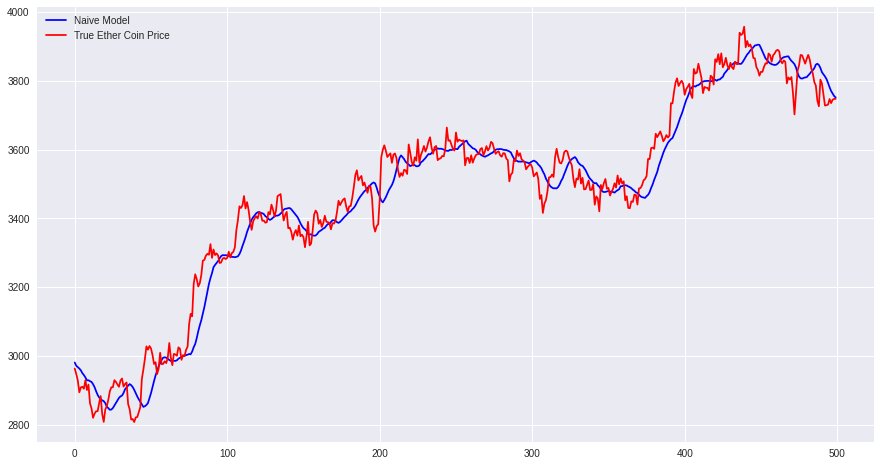

In [78]:
y_pred_trans = y_scaler.inverse_transform(np.array(naive_pred).reshape(-1,1))
y_test_trans = y_scaler.inverse_transform(test_Y.reshape(-1,1))

plt.figure(figsize=(15,8))
plt.plot(y_pred_trans[-500:], color='blue', label='Naive Model')
plt.plot(y_test_trans[-500:], color='red', label='True Ether Coin Price')
plt.legend()

### Bi-Directional GRU Model

In [24]:
class GRU_Model(nn.Module):
    
    def __init__(self, input_size, output_size,  hidden_dim, n_layers, fc1_size, fc2_size, dropout=0):
        super(GRU_Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers 
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.dropout = dropout

        self.gru = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_dim,
                 num_layers=self.n_layers, batch_first=True, bidirectional=True, dropout=self.dropout)
        self.FC = nn.Sequential(
            nn.Linear(2*self.hidden_dim, self.fc1_size),
            nn.ReLU(),
            nn.Linear(self.fc1_size, self.fc2_size),
            nn.Linear(self.fc2_size, self.output_size)
        )

    
    def forward(self, x):
        h0 = torch.zeros(2*self.n_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn) = self.gru(x, (h0.to(device)))
        out = self.FC(out[:,-1, :])
        return out

In [25]:
class Ether_Dataset(Dataset):
    def __init__(self, features, target):
        super(Ether_Dataset, self).__init__()
        self.features = torch.Tensor(features)
        self.target = torch.Tensor(target)

    def __getitem__(self, index):
        return self.features[index], self.target[index]

    def __len__(self):
        return self.target.size()[0]

In [65]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0005, 
                epochs=20, batch_size=32, patience=5, gamma=0.5, l2=0):

    best_loss = 0.02
    PATH = 'model.pt'

    # Construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Move model to device
    model = model.to(device)

    # Initialize training history

    print('Price Regression Model\n')
    train_history = {'train_loss':[], 'test_loss':[]}
    criterion = nn.MSELoss()

    # Adam optimizer + learning schedule
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)

    print('\nTraining Start')
    print(65*'=')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            # forward pass
            outputs = model(x).view(-1)

            cur_train_loss = criterion(outputs, y)

            # backward pass
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += cur_train_loss 
        
        # Test Start
        model.eval()
        with torch.no_grad():
            predictions = []
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                # Forward Pass
                outputs = model(x).view(-1)

                predictions.append(outputs.cpu().numpy())

                cur_test_loss = criterion(outputs, y)
                test_loss += cur_test_loss

        scheduler.step()

        train_loss = (train_loss/len(train_loader)).item()
        test_loss = (test_loss/len(test_loader)).item()

        if test_loss < best_loss:
            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': test_loss,}, PATH)
            print('Model saved...')

            best_predictions = predictions
        
        best_loss = min(test_loss, best_loss)

        train_history['train_loss'].append(train_loss)
        train_history['test_loss'].append(test_loss)


        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f}, lr: {optimizer.param_groups[0]["lr"]:.5f}')

    return train_history, best_predictions

In [66]:
def inverse_transform(scaler, df, cols):
    for col in cols:
        df[col] = scaler.inverse_transform(df[col])
    return df
    
def results(predictions, test_values, scaler):
    predictions = np.concatenate(predictions).ravel()
    df_res = pd.DataFrame({'true_values':test_values, 'pred_values':predictions}, index=range(len(test_values)))
    df_res = inverse_transform(scaler, df_res, cols = [['true_values', 'pred_values']])
    return df_res

In [67]:
import random

random.seed(0)
torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [68]:
x_train = X[:train_test_cut_off]
y_train = Y[:train_test_cut_off]

x_test = X[train_test_cut_off:]
y_test = Y[train_test_cut_off:]

train_dataset = Ether_Dataset(x_train, y_train)
test_dataset = Ether_Dataset(x_test, y_test)

In [110]:
# Model configuration
input_size = 12
output_size = 1
hidden_dim = 144
n_layers = 1
fc1_size = 24
fc2_size = 12
dropout = 0.6

In [111]:
# Training parameters
lr=0.0003 
epochs=50
batch_size=64
patience=4 
gamma=0.95
l2=0

In [112]:
model = GRU_Model(input_size, output_size, hidden_dim, n_layers, fc1_size, fc2_size)
summary(model, (32,12,12))

Layer (type:depth-idx)                   Output Shape              Param #
GRU_Model                                --                        --
├─GRU: 1-1                               [32, 12, 288]             136,512
├─Sequential: 1-2                        [32, 1]                   --
│    └─Linear: 2-1                       [32, 24]                  6,936
│    └─ReLU: 2-2                         [32, 24]                  --
│    └─Linear: 2-3                       [32, 12]                  300
│    └─Linear: 2-4                       [32, 1]                   13
Total params: 143,761
Trainable params: 143,761
Non-trainable params: 0
Total mult-adds (M): 52.65
Input size (MB): 0.02
Forward/backward pass size (MB): 0.89
Params size (MB): 0.58
Estimated Total Size (MB): 1.49

In [113]:
train_hist, pred = train_model(model, train_dataset, test_dataset, device,
                               lr, epochs, batch_size, patience, gamma, l2)

Price Regression Model


Training Start
Epoch: 1/50, Train Loss: 0.00313 Test Loss: 1.37205, lr: 0.00030
Epoch: 2/50, Train Loss: 0.00191 Test Loss: 1.03400, lr: 0.00030
Epoch: 3/50, Train Loss: 0.00109 Test Loss: 0.80525, lr: 0.00030
Epoch: 4/50, Train Loss: 0.00069 Test Loss: 0.55234, lr: 0.00028
Epoch: 5/50, Train Loss: 0.00034 Test Loss: 0.33921, lr: 0.00028
Epoch: 6/50, Train Loss: 0.00013 Test Loss: 0.23978, lr: 0.00028
Epoch: 7/50, Train Loss: 0.00009 Test Loss: 0.20968, lr: 0.00028
Epoch: 8/50, Train Loss: 0.00007 Test Loss: 0.16677, lr: 0.00027
Epoch: 9/50, Train Loss: 0.00007 Test Loss: 0.11471, lr: 0.00027
Epoch: 10/50, Train Loss: 0.00007 Test Loss: 0.05520, lr: 0.00027
Model saved...
Epoch: 11/50, Train Loss: 0.00008 Test Loss: 0.01717, lr: 0.00027
Model saved...
Epoch: 12/50, Train Loss: 0.00008 Test Loss: 0.00973, lr: 0.00026
Model saved...
Epoch: 13/50, Train Loss: 0.00007 Test Loss: 0.00627, lr: 0.00026
Model saved...
Epoch: 14/50, Train Loss: 0.00006 Test Loss: 0.0061

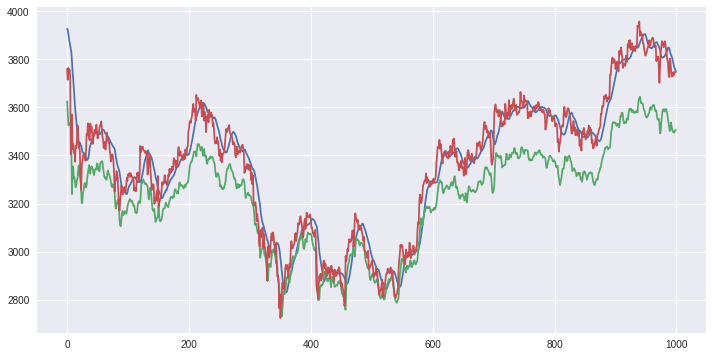

In [114]:
results_df = results(pred, y_test, y_scaler)
x = np.arange(1000)

plt.figure(figsize=(12,6))
plt.plot(x, y_pred_trans[-1000:])
plt.plot(x, results_df['pred_values'][-1000:])
plt.plot(x, results_df['true_values'][-1000:])